In [23]:
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

import torch
from torch import nn
from ipynb.fs.full.model import VariationalAutoEncoder
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, RandomSampler
from torchvision.utils import save_image 

### loading model

configuration:

In [24]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 256
INIT_DIM = 8
LATENT_DIM = 3
BATCH_SIZE = 1
LR_RATE = 3e-4
KERNEL_SIZE = 4

loading the dataset

In [49]:
# Dataset Loading
data_path = 'dataset' # setting path
transform = transforms.Compose([transforms.Resize((INPUT_DIM, INPUT_DIM)),   # sequence of transformations to be done
                                transforms.Grayscale(num_output_channels=1), # on each image (resize, greyscale,
                                transforms.ToTensor()])                      # convert to tensor)

dataset = datasets.ImageFolder(root=data_path, transform=transform) # read data from folder

train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True) # create dataloader object

model = VariationalAutoEncoder(init_dim=INIT_DIM, latent_dim=LATENT_DIM, kernel_size=KERNEL_SIZE).to(DEVICE) # initializing model object

optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE) # defining optimizer
loss_fn = nn.BCELoss(reduction='sum') # define loss function

loading model

In [50]:
model = VariationalAutoEncoder(init_dim=INIT_DIM, latent_dim=LATENT_DIM, kernel_size=KERNEL_SIZE)
model.load_state_dict(torch.load('models/test_overfitting'))
model.eval()

VariationalAutoEncoder(
  (enc1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=14400, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=3, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=256, bias=True)
  (dec1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
  (dec2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec5): ConvTranspose2d(32, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec6): ConvTranspose2d

### helper functions

In [51]:
def reconstruct(img): # img is a tensor
    with torch.no_grad():
        mu, sigma = model.encode(img.view(1,256,256)) # get encoding of image
    out = model.decode(mu)
    out = out.view(-1, 1, 256, 256)
    save_image(out, 'temp.png')
    out = cv2.imread('temp.png')
    os.remove('temp.png')
    return out, mu, sigma

In [52]:
def preprocess_image(img): # img is a array
    img = img/255
    thresh = img.flatten().mean()
    im_bw = 1 - cv2.threshold(img, thresh, 1, cv2.THRESH_BINARY)[1]
    return im_bw

### comparing the reconstruction with input image

In [53]:
def compare_reconstruction(img, plot=True): # img is a tensor
    output, mu, sigma = reconstruct(img)
    img = img.numpy()[0]
    bw_output = preprocess_image(output)
    bw_img = preprocess_image(img*255)
    output_porosity = ps.metrics.porosity(bw_output)
    img_porosity = ps.metrics.porosity(bw_img)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
        ax1.imshow(img, cmap = 'gray')
        ax1.set_title('Original image')
        ax1.set_xlabel(f'Porosity: {img_porosity}')
        ax2.imshow(output)
        ax2.set_xlabel(f'Porosity: {output_porosity}')
        ax2.set_title('Reconstructed image')
        
    return img_porosity, output_porosity, mu, sigma

tensor([ 1.2766, -0.6936,  0.0309]) tensor([ 0.0564, -0.0129,  0.0127])


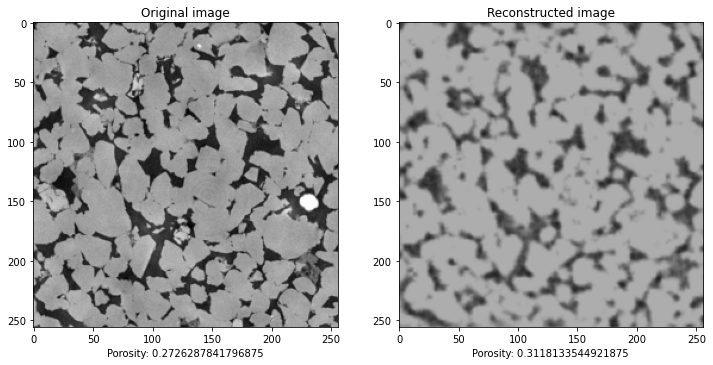

In [55]:
i = np.random.choice(200)
_, _, mu, sigma = compare_reconstruction(dataset[i][0])
print(mu , sigma)

In [12]:
porosity_error = []
for i in tqdm(range(len(dataset))):
    img_porosity, output_porosity, _, _ = compare_reconstruction(dataset[i][0], plot=False)
    err = np.abs(img_porosity - output_porosity)
    porosity_error.append(err)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 45.05it/s]


<AxesSubplot:ylabel='Count'>

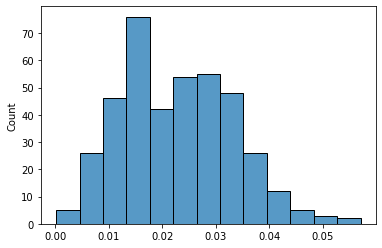

In [13]:
import seaborn as sns

sns.histplot(porosity_error)